# Blood Donation

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd

from pylab import rcParams      
rcParams['figure.figsize'] = 8, 8
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [22]:
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score, roc_curve, auc
from sklearn.cross_validation import train_test_split

In [24]:
def plot_roc_curve(predictions):
    preds = predictions[:,1]
    fpr, tpr, threshold = roc_curve(yval, preds)
    roc_auc = auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [90]:
train = pd.read_csv("/Users/dmitrys/Desktop/DataProjects/BloodDonations/train.csv")
test = pd.read_csv("/Users/dmitrys/Desktop/DataProjects/BloodDonations/test.csv")
submission = pd.read_csv("/Users/dmitrys/Desktop/DataProjects/BloodDonations/BloodDonationSubmissionFormat.csv")

In [91]:
train.head()

,Unnamed: 0,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
0,619,2,50,12500,98,1
1,664,0,13,3250,28,1
2,441,1,16,4000,35,1
3,160,2,20,5000,45,1
4,358,1,24,6000,77,0


In [92]:
test.head()

,Unnamed: 0,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation
0,659,2,12,3000,52
1,276,21,7,1750,38
2,263,4,1,250,4
3,303,11,11,2750,38
4,83,4,12,3000,34


In [93]:
train["Test"] = False
test["Test"] = True
data = pd.concat([train, test], ignore_index=True)

In [94]:
data.describe()

,Made Donation in March 2007,Months since First Donation,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Unnamed: 0
count,576.000000,776.000000,776.000000,776.000000,776.000000,776.000000
mean,0.239583,34.417526,9.453608,5.557990,1389.497423,374.171392
std,0.427200,24.450047,8.030935,5.841939,1460.484632,215.330133
min,0.000000,2.000000,0.000000,1.000000,250.000000,0.000000
25%,0.000000,16.000000,3.000000,2.000000,500.000000,187.750000
50%,0.000000,28.000000,7.000000,4.000000,1000.000000,375.500000
75%,0.000000,50.000000,14.000000,7.000000,1750.000000,558.250000
max,1.000000,98.000000,74.000000,50.000000,12500.000000,747.000000


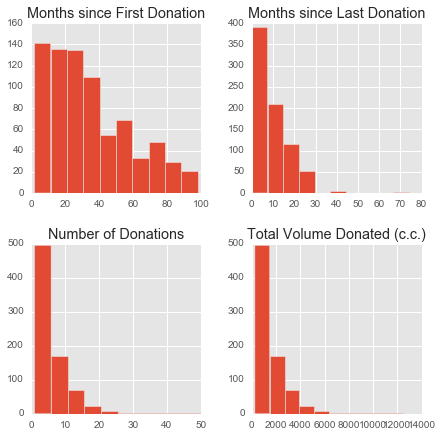

In [95]:
(data.drop(["Unnamed: 0", "Made Donation in March 2007", "Test"], axis=1)).hist(figsize=(7, 7));

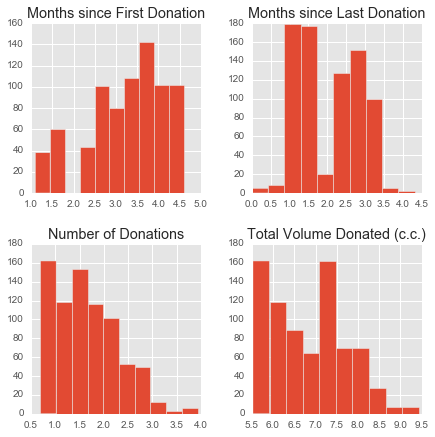

In [96]:
(data.drop(["Unnamed: 0", "Made Donation in March 2007", "Test"], axis=1)+1).apply(np.log).hist(figsize=(7, 7));

In [97]:
y = train['Made Donation in March 2007']
train.drop(['Made Donation in March 2007', 'Unnamed: 0'], axis = 1, inplace=True)
indecies = list(test["Unnamed: 0"])
test.drop(['Unnamed: 0'], axis = 1, inplace=True)

In [99]:
X = (train+1).apply(np.log)

In [100]:
Xtr, Xval, ytr, yval = train_test_split(X, y, test_size=0.3, random_state=42)

In [101]:
Xtr.shape, Xval.shape

((403, 5), (173, 5))

In [102]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000, n_jobs=3)
rf.fit(Xtr, ytr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=3, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [103]:
print(log_loss(yval, rf.predict_proba(Xval)))
print(roc_auc_score(yval, rf.predict_proba(Xval)[:,1]))

0.822785055693
0.699473337722


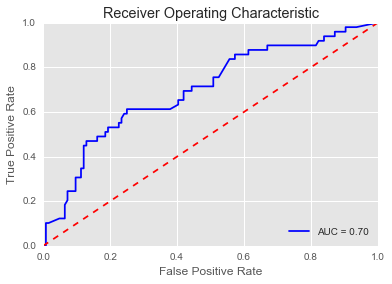

In [104]:
plot_roc_curve(rf.predict_proba(Xval))

In [26]:
from sklearn.calibration import CalibratedClassifierCV
calib = CalibratedClassifierCV(RandomForestClassifier(n_jobs=3, n_estimators=1000), cv=10, method='isotonic')
calib.fit(Xtr, ytr)


CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=3, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
            cv=10, method='isotonic')

In [27]:
print(log_loss(yval, calib.predict_proba(Xval)))
print(roc_auc_score(yval, calib.predict(Xval)))

0.571117572289
0.604674127716


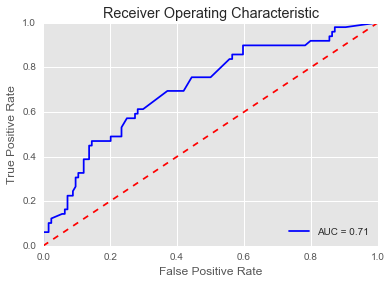

In [29]:
plot_roc_curve(calib.predict_proba(Xval))

In [30]:
import sys
sys.path.append('/Users/dmitrys//xgboost/python-package/')
import xgboost as xgb

In [31]:
dtrain = xgb.DMatrix(X, label=y)

In [32]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 5,
    'eta': 0.001,
    'subsample': 0.5,
    'min_child_weight': 1,
    'colsample_bytree':0.6
}
trees = 200

In [33]:
cv = xgb.cv(params, dtrain, metrics=('auc'), verbose_eval=False, nfold=7, show_stdv=False, num_boost_round=trees)

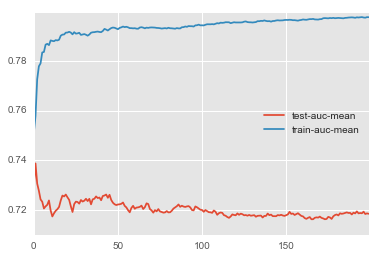

In [34]:
cv.plot(y=['test-auc-mean', 'train-auc-mean'])

In [35]:
cv.loc[cv['test-auc-mean'].argmax()]

test-auc-mean     0.738789
test-auc-std      0.054651
train-auc-mean    0.757923
train-auc-std     0.017633
Name: 1, dtype: float64

In [36]:
cv['test-auc-mean'].argmax()

1

In [37]:
bst = xgb.train(params, dtrain, num_boost_round=75)

In [38]:
imps = pd.Series(bst.get_fscore()).sort_values()

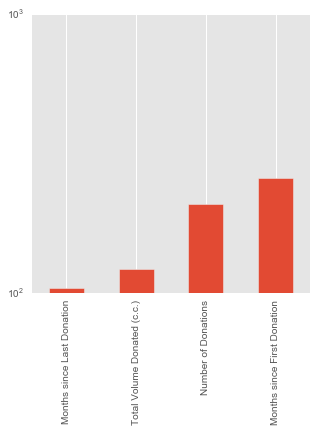

In [39]:
imps.plot(kind='bar', figsize=(5,5),logy=True)

             precision    recall  f1-score   support

          0       0.72      1.00      0.84       124
          1       0.00      0.00      0.00        49

avg / total       0.51      0.72      0.60       173

[[124   0]
 [ 49   0]]


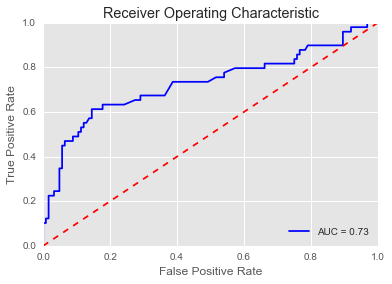

In [105]:
from sklearn import metrics
from sklearn.svm import SVC
# fit a SVM model to the data

model_SVM = SVC(probability=True)
model_SVM.fit(Xtr, ytr)
#print(model_SVM)
# make predictions
expected = yval
predicted = model_SVM.predict(Xval)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
plot_roc_curve(model_SVM.predict_proba(Xval))

GaussianNB(priors=None)
             precision    recall  f1-score   support

          0       0.78      0.91      0.84       124
          1       0.62      0.37      0.46        49

avg / total       0.74      0.76      0.74       173

[[113  11]
 [ 31  18]]


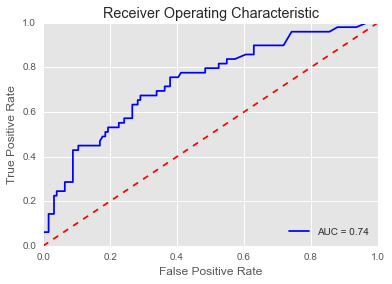

In [106]:
from sklearn.naive_bayes import GaussianNB
model_B = GaussianNB()
model_B.fit(Xtr, ytr)
print(model_B)
# make predictions
expected = yval
predicted = model_B.predict(Xval)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
plot_roc_curve(model_B.predict_proba(Xval))

('Train logloss', 0.46971688149262003)
('Train roc_auc', 0.53061261003363636)
('Validation logloss', 0.50927206496421251)
('Validation roc_auc', 0.52254772876892697)


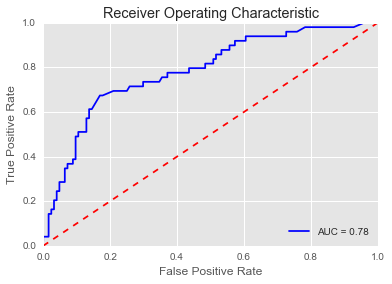

In [107]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(Xtr, ytr)

print('Train logloss', log_loss(ytr, lr.predict_proba(Xtr)))
print('Train roc_auc', roc_auc_score(ytr, lr.predict(Xtr)))
print('Validation logloss', log_loss(yval, lr.predict_proba(Xval)))
print('Validation roc_auc', roc_auc_score(yval, lr.predict(Xval)))
plot_roc_curve(lr.predict_proba(Xval))

In [108]:
from sklearn.grid_search import GridSearchCV
Cs = 10**np.linspace(-5, 7, num=30)
grid = {'C': Cs}
gridsearch = GridSearchCV(LogisticRegression(), grid, scoring='neg_log_loss', cv=6)
%time gridsearch.fit(X, y)

CPU times: user 974 ms, sys: 5.26 ms, total: 979 ms
Wall time: 999 ms


GridSearchCV(cv=6, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-05,   2.59294e-05,   6.72336e-05,   1.74333e-04,
         4.52035e-04,   1.17210e-03,   3.03920e-03,   7.88046e-03,
         2.04336e-02,   5.29832e-02,   1.37382e-01,   3.56225e-01,
         9.23671e-01,   2.39503e+00,   6.21017e+00,   1.61026e+01,
         4.1753...    8.53168e+04,   2.21222e+05,   5.73615e+05,   1.48735e+06,
         3.85662e+06,   1.00000e+07])},
       pre_dispatch='2*n_jobs', refit=True, scoring='neg_log_loss',
       verbose=0)

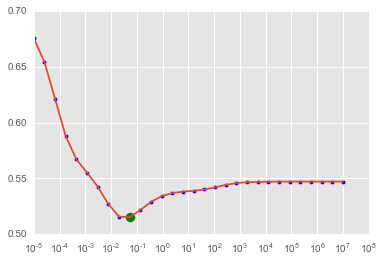

In [109]:
scores = [-x.mean_validation_score for x in  gridsearch.grid_scores_]
plt.plot(Cs, scores)
plt.scatter(Cs, scores)
plt.scatter(Cs[np.argmin(scores)], scores[np.argmin(scores)], c='g', s=100)
plt.xscale('log')

In [110]:
C = Cs[np.argmin(scores)]
C

0.052983169062837072

('Train logloss', 0.48247798705916944)
('Train roc_auc', 0.5112359550561798)
('Validation logloss', 0.52380411959902162)
('Validation roc_auc', 0.51020408163265307)


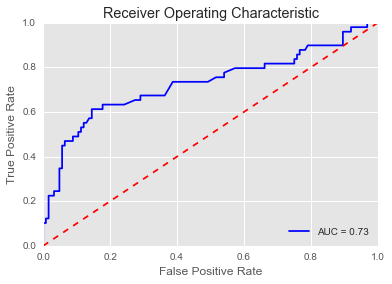

In [111]:
lr = LogisticRegression(C=C)
lr.fit(Xtr, ytr)
print('Train logloss', log_loss(ytr, lr.predict_proba(Xtr)))
print('Train roc_auc', roc_auc_score(ytr, lr.predict(Xtr)))
print('Validation logloss', log_loss(yval, lr.predict_proba(Xval)))
print('Validation roc_auc', roc_auc_score(yval, lr.predict(Xval)))
plot_roc_curve(model_SVM.predict_proba(Xval))

In [56]:
xgb_prediction = bst.predict(xgb.DMatrix(test))

In [117]:
to_submit = pd.DataFrame(lr.predict_proba((test+1).apply(np.log))[:,1], index=indecies, columns=["Made Donation in March 2007"])

In [118]:
to_submit.to_csv('/Users/dmitrys/Desktop/DataProjects/BloodDonations/submission.csv')

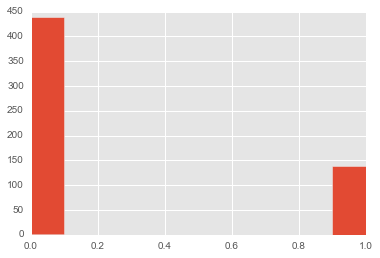

In [119]:
y.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1277db890>]], dtype=object)

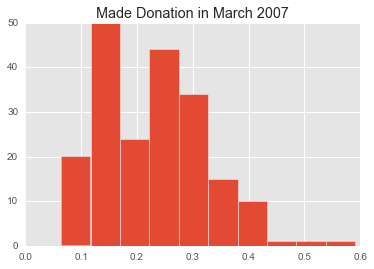

In [120]:
to_submit.hist()